# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour image segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```

## What to do?

* Complete and run the code using `jupyter-lab` or `jupyter-notebook` to get the results.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* Instead of clicking the Export button, you can also run the following command instead: `jupyter nbconvert coursework.ipynb --to pdf`

* If Jupyter complains about some problems in exporting, it is likely that pandoc (https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry.

* If Jupyter-lab does not work for you at the end, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [2]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import imageio.v2 as imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors


## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

In [3]:
### Insert your code ###

fig = plt.figure() 
  
# setting values to rows and column variables 
rows = 4
columns = 2



for i in range(0,8,2):
    rand_file = random.choice(os.listdir("Task01_BrainTumour_2D/training_labels/"))
    im_path = os.path.join("Task01_BrainTumour_2D/training_images/" , rand_file)
    lab_path = os.path.join("Task01_BrainTumour_2D/training_labels/" , rand_file)
    



    train_im = fig.add_subplot(rows,columns, i+1)
    image = imageio.imread(im_path)
    train_im.title.set_text("Training Image")
    train_im.axis('off')
    plt.imshow(image, cmap='gray')
    plt.gcf().set_size_inches(16, 16)

    train_lab = fig.add_subplot(rows,columns, i+2)
    label = imageio.imread(lab_path)
    train_lab.title.set_text("Label map")#
    train_lab.axis('off')
    plt.imshow(label, cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
    plt.gcf().set_size_inches(16, 16)



### End of your code ###

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Task01_BrainTumour_2D/training_labels/'

<Figure size 640x480 with 0 Axes>

## 2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, as training batches.

In [4]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        
        train_size = len(os.listdir(self.image_path))
        rand_index = np.array(random.sample(range(train_size), batch_size))
        
        for x in rand_index:
            images.append(self.images[x])
            labels.append(self.labels[x])

        images = np.array(images)
        labels = np.array(labels)

        images =  np.expand_dims(images, axis = 1)

        ### End of your code ###
        return images, labels
    

## 3. Build a U-net architecture.

You will implement a U-net architecture. If you are not familiar with U-net, please read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [5]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.
        # Encoder path
        n = num_filter  # 16
        # print(n)
        self.conv1 = nn.Sequential(
            nn.Conv2d(input_channel, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 32
        # print(n)

        self.conv2 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 64
        # print(n)

        self.conv3 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )

        n *= 2  # 128
        # print(n)

        self.conv4 = nn.Sequential(
            nn.Conv2d(int(n / 2), n, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding=1),
            nn.BatchNorm2d(n),
            nn.ReLU()
        )
        

        # Decoder path
        ### Insert your code ###
        n //= 2 
        # print(n)

        self.transconv1 = nn.Sequential(
            nn.ConvTranspose2d(int(2*n), n, kernel_size = 3, stride = 2, padding = 1, output_padding= 1),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding = 1),
            nn.BatchNorm2d(n),
            nn.LeakyReLU()
        )

        n //= 2 
        # print(n)

        self.transconv2 = nn.Sequential(
            nn.ConvTranspose2d(int(4*n), n, kernel_size = 3, stride = 2, padding = 1,output_padding= 1),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding = 1),
            nn.BatchNorm2d(n),
            nn.LeakyReLU()
        )

        n //= 2 
        # print(n)

        self.transconv3 = nn.Sequential(
            nn.ConvTranspose2d(int(4*n), n, kernel_size = 3, stride = 2, padding = 1, output_padding= 1),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(),
            nn.Conv2d(n, n, kernel_size=3, padding = 1),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(),
        )

        n //= 2
        # print(n)

        self.output = nn.Sequential(
            nn.Conv2d(int(4*n), n, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(n),
            nn.LeakyReLU(),
            nn.Conv2d(n, output_channel, kernel_size=1),
            nn.BatchNorm2d(output_channel),
            nn.LeakyReLU()
        )

        ### End of your code ###


    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        print("0 " + str(x.shape))
        x = self.conv1(x)
        print("1 " + str(x.shape))
        conv1_skip = x

        x = self.conv2(x)
        print("2 " + str(x.shape))

        conv2_skip = x

        x = self.conv3(x)
        print("3 " + str(x.shape))

        conv3_skip = x

        x = self.conv4(x)
        print("4 " + str(x.shape))

        # Decoder
        ### Insert your code ###
        x = self.transconv1(x)
        x = torch.cat((x, conv3_skip),dim = 1)

        print("5 " + str(x.shape))


        x = self.transconv2(x)
        x = torch.cat((x, conv2_skip),dim = 1)

        print("6 " + str(x.shape))


        x = self.transconv3(x)
        x = torch.cat((x, conv1_skip),dim = 1)
        
        print("7 " + str(x.shape))


        x = self.output(x)
        
        print("8 " + str(x.shape))


        ### End of your code ###
        return x


num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)

## 4. Train the segmentation model.

In [6]:
# CUDA device
print(torch.__version__)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
meow = []
x_axis = []
start = time.time()
for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = train_set.get_random_batch(train_batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)

    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    optimizer.zero_grad()

    loss = criterion(logits, labels)

    loss.backward()
    optimizer.step()
    ### End of your code ###

    # Evaluate
    if it % 100 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            eval_images, eval_labels = test_set.get_random_batch(eval_batch_size)
            eval_images, eval_labels = torch.from_numpy(eval_images), torch.from_numpy(eval_labels)
            eval_images, eval_labels = eval_images.to(device, dtype=torch.float32), eval_labels.to(device, dtype=torch.long)
            forward_eval = model(eval_images)
            test_loss = criterion(forward_eval, eval_labels)
            print("Test loss at iteration {0}: ".format(it) + str(test_loss.item()))
            meow.append(test_loss.item())
            x_axis.append(it)
            

            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
        
print('Training took {:.3f}s in total.'.format(time.time() - start))
fig, ax = plt.subplots()
ax.plot(np.array(x_axis), np.array(meow))

ax.set(xlabel='iteration', ylabel='test loss',
title='test loss vs no. of iterations')
ax.grid()
plt.show()



2.2.1+cu118
Device: cuda


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Task01_BrainTumour_2D/training_images'

## 5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

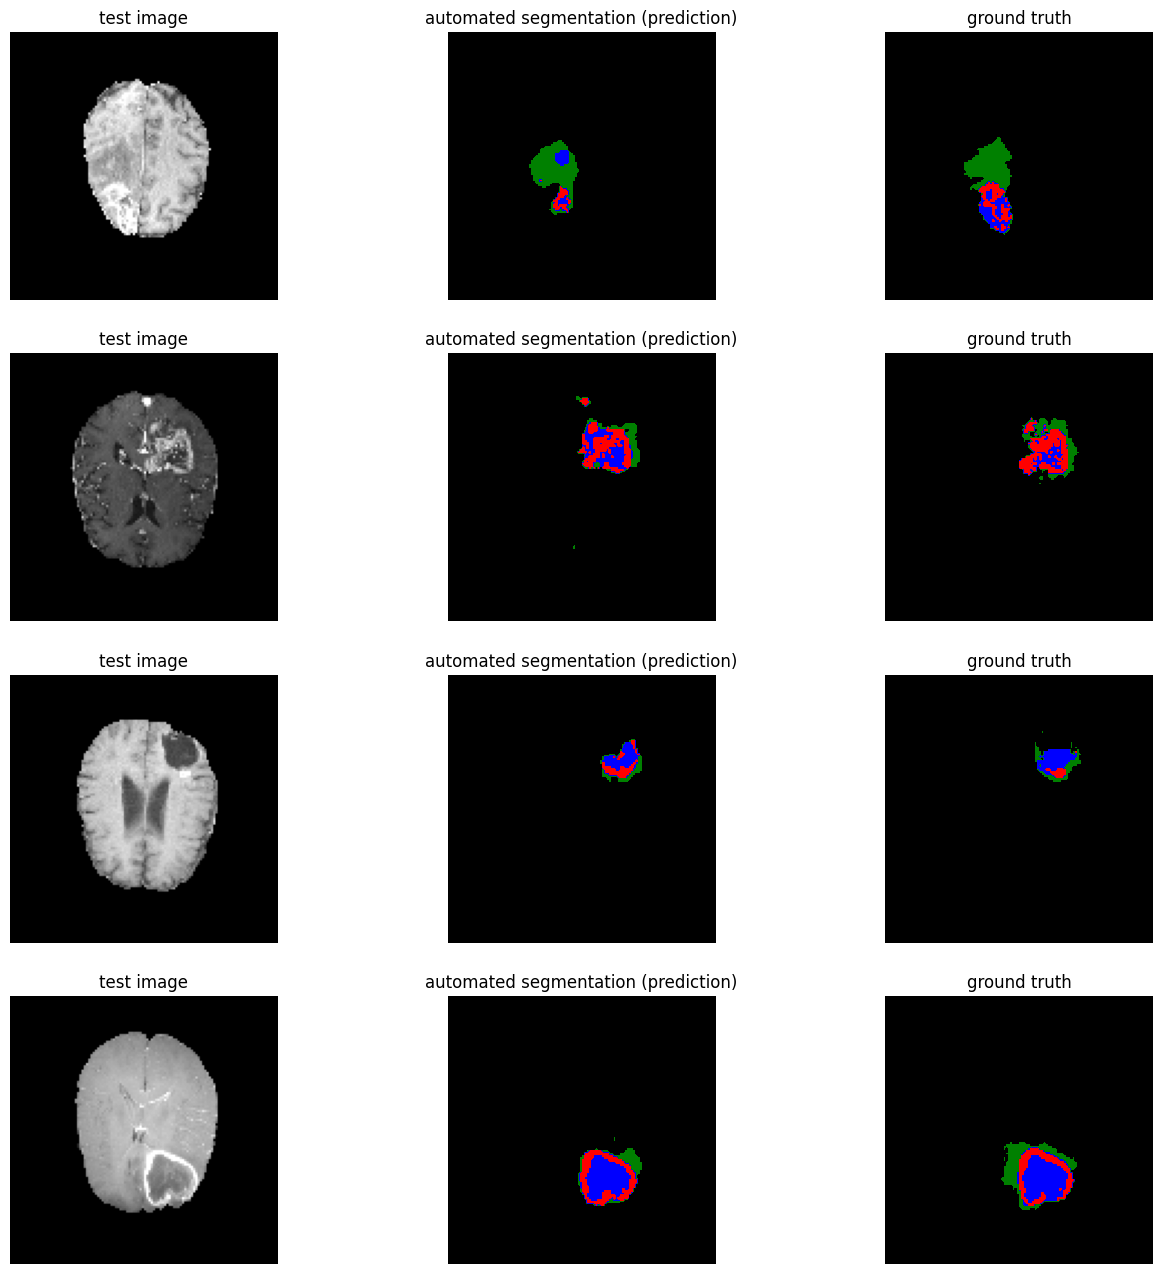

In [19]:
### Insert your code ###

test_images, test_labels = test_set.get_random_batch(4)
test_images, test_labels = torch.from_numpy(test_images), torch.from_numpy(test_labels)
test_images, test_labels = test_images.to(device, dtype=torch.float32), test_labels.to(device, dtype=torch.long)
forward_eval = model(test_images)



model.eval()
with torch.no_grad():

    fig = plt.figure() 
    
    # setting values to rows and column variables 
    rows = 4
    columns = 3

    for i in range(0,12,3):
        
        
        meep  = fig.add_subplot(rows,columns, i+1 )
        meep.title.set_text("test image")
        meep.axis('off')
        test_image = np.array(test_images[i//3].cpu()[0])
        plt.imshow(test_image, cmap='gray')
        plt.gcf().set_size_inches(16, 16)


        sheep = fig.add_subplot(rows,columns, i+2)
        sheep.title.set_text("automated segmentation (prediction)")
        sheep.axis('off') 
        auto_seg = np.array(forward_eval[i//3].cpu())
        plt.imshow(np.argmax(auto_seg, axis = 0), cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
        plt.gcf().set_size_inches(16, 16)


        boy = fig.add_subplot(rows,columns, i+3)
        boy.title.set_text("ground truth") 
        boy.axis('off')
        ground_truth_seg = np.array(test_labels[i//3].cpu())
        plt.imshow(ground_truth_seg, cmap=colors.ListedColormap(['black', 'green', 'blue', 'red']))
        plt.gcf().set_size_inches(16, 16)





### End of your code ###
        
        
        

## 6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?

The model is able to detect regions of interest in the brain scans quite well for larger tumour/edema patterns with a relatively round shape. However, the accuracy of its segmentation results seem to reduce when the scan contains a tumour (either kind) or an edema that possesses a more irregular shape or occupies a smaller area on its own. Another issue was encountered when the model would occasionally detect a tumour when there wasn't any.

This reduction may stem from the model's tendency to overfit to certain tumor configurations, likely due to a higher prevalence of such patterns in the training data. This could be addressed by utilising data augmentation in which affine transformations (such as translation, scaling, shearing and squeezing) to, which should create more training samples in the presentations of brain cancer with lower segmentation performance (e.g. tumours with irregular, less rounded shapes). This should result in an improved segmentation model which is better able to generalise tumour/edema patterns from the training data and is therefore robust to a broader sprectrum of cancerous MRI scans.

In order to improve the model for real world clinical deployment, it is important that the segmentation network achieves high sensitivity in detecting all cancerous lesions. No patient with cancer should be overlooked. At the same time, while there may be an acceptable rate of false positive results to avoid overlooking patients, it is important to ensure that the false positive rate of the model is not so high as to render it pointless as a diagnostic tool, as false positives can cause a lot of undue stress on a patient. Therefore, rigorous validation and testing procedures are necessary to ensure the model's reliability in clinical practice. Perhaps hyperparameter tuning could be carried out to optimise things such as filter size to improve intersection over union (IOU) performance of the model. Dropout could also be implemented to reduce overfitting to any one pattern of tumours in the dataset.

 Collaboration with healthcare professionals for thorough validation and integration into existing clinical workflows is crucial for successful deployment, perhaps with qualified professionals consulting the results to verify their accuracy and to catch mistakes.
